In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")

from scripts.neutMakeJson import main as MakeNeutJson
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas

Welcome to JupyROOT 6.27/01


In [2]:
ROOT.rand = ROOT.TRandom3()

def poisson(x, mean):
    """
    ensure that mean is some int
    """
    assert isinstance(mean, int), "can only have integer mean values"
    x = int(x) # poisson only makes sense for int args
    return ROOT.TMath.Poisson(x,mean)

def gamma(x, mean):
    return 1 - ROOT.TMath.Gamma(x, mean)

def uniform():
    return ROOT.rand.Uniform()

def randomPoisson(mean, nSamples):
    """
    randomly sample the poisson to return number of events
    """
    assert isinstance(nSamples, int), "need integer number of samples to draw from"
    samples = [ROOT.rand.Poisson(mean) for i in range(nSamples)]
    return samples

def randomErlang(mean, nEvts, nSamples):
    """
    randomly sample the gamma to return number of events
    """
    assert isinstance(nSamples, int), "need integer number of samples to draw from"
    def erlang():
        return -1 * np.sum([ROOT.TMath.Log(ROOT.rand.Uniform()) for i in range(nEvts)]) / mean
    samples = [erlang() for i in range(nSamples)]
    return samples

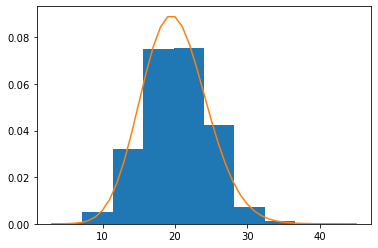

In [3]:
mean, nSamples = 20, int(3e5)
samples = randomPoisson(mean, nSamples)
a = plt.hist(samples, density=True)
x = np.arange(int(np.min(a[1])), int(np.max(a[1]))+1)
p1 = [poisson(i, mean) for i in x]
plt.plot(x,p1)

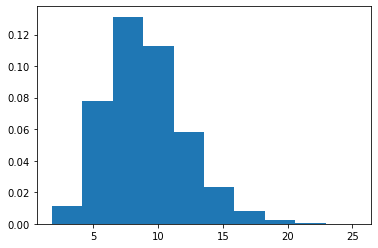

In [4]:
mean, nEvts, nSamples = 1, 9, int(1e4)
samples = randomErlang(mean, nEvts, nSamples)
a = plt.hist(samples, density=True)

In [5]:
print(type(ROOT.rand), type(ROOT.TRandom()))

<class cppyy.gbl.TRandom3 at 0x556f011f92c0> <class cppyy.gbl.TRandom at 0x556f04c5cc50>


In [6]:
import numpy as np

def printArr(x):
    for i, row in enumerate(x):
        print(f"{i} - ", end="")
        for j, d in enumerate(row):
            print(f"({d:.0f})", end="")
        print()

def route(x, r=0, type="snake"):
    """
    args: r is the row position of the daq-node
    """
    assert all(isinstance(row, (list, np.ndarray)) for row in x), f"{x} not a matrix"
    row_size = len(x)
    col_size = len(x[0])
    assert all(len(ele) == col_size for ele in x), f"col sizes different in {x}"
    
    # parameterize this for general di location
    # edge = 
    
    def makeSnake(x):
        # snake if DAQ on left
        for i, row in enumerate(x):
            for j, d in enumerate(row):            
                if not(i%2 == 0) and j == col_size-1:
                    x[i][j] = 1
                elif i%2 == 0:
                    if j == 0 and not(i == 0):
                        x[i][j] = 1
                    else:
                        x[i][j] = 3
                else:
                    x[i][j] = 2                
        return x
    
    def makeTrunk(x, r):
        for i, row in enumerate(x):
            for j, d in enumerate(row):            
                if j == r:
                    x[i][j] = 1
                elif j < r:
                    x[i][j] = 3
                else:
                    x[i][j] = 2                
        return x
    
    if type=="snake":
        return makeSnake(x)
    elif type=="trunk":
        return makeTrunk(x, r)
    else:
        print("unrecognized type")
        return None

        
x = np.zeros((8,8))

print("snake")
printArr(route(x))
print("trunk")
printArr(route(x, r=2,type="trunk"))

snake
0 - (3)(3)(3)(3)(3)(3)(3)(3)
1 - (2)(2)(2)(2)(2)(2)(2)(1)
2 - (1)(3)(3)(3)(3)(3)(3)(3)
3 - (2)(2)(2)(2)(2)(2)(2)(1)
4 - (1)(3)(3)(3)(3)(3)(3)(3)
5 - (2)(2)(2)(2)(2)(2)(2)(1)
6 - (1)(3)(3)(3)(3)(3)(3)(3)
7 - (2)(2)(2)(2)(2)(2)(2)(1)
trunk
0 - (3)(3)(1)(2)(2)(2)(2)(2)
1 - (3)(3)(1)(2)(2)(2)(2)(2)
2 - (3)(3)(1)(2)(2)(2)(2)(2)
3 - (3)(3)(1)(2)(2)(2)(2)(2)
4 - (3)(3)(1)(2)(2)(2)(2)(2)
5 - (3)(3)(1)(2)(2)(2)(2)(2)
6 - (3)(3)(1)(2)(2)(2)(2)(2)
7 - (3)(3)(1)(2)(2)(2)(2)(2)


In [6]:
import pandas as pd
df = pd.read_feather("../../scripts/neutMP60k.feather")
print(df.head)
routes = pd.unique(df['Route'])
# print(routes)

<bound method NDFrame.head of       Architecture Route                                      Injected Hits  \
0             Push  None                                                 []   
1             Push  None                                                 []   
2             Push  None                                                 []   
3             Push  None                                                 []   
4             Push  None                                                 []   
...            ...   ...                                                ...   
59983         Push  left  [0.01818132257938032, 0.018181499011319602, 0....   
59984         Push  left  [0.01818132257938032, 0.018181499011319602, 0....   
59985         Push  left  [0.01818132257938032, 0.018181499011319602, 0....   
59986         Push  left  [0.01818132257938032, 0.018181499011319602, 0....   
59987         Push  left  [0.01818132257938032, 0.018181499011319602, 0....   

       Injected Size 